In [1]:
from PIL import Image
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import h5py
from matplotlib import pyplot as plt
%matplotlib inline

# Import Images

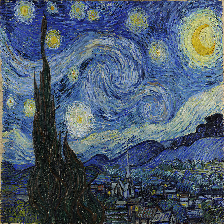

In [2]:
im = Image.open('starry_night.jpg')
im2 = im.resize([224,224])
style = np.array(im2,dtype=np.float32).reshape((224,224,3))
im2

In [3]:
im = Image.open('IMG_8205.jpg')
im2 = im.crop(box=[700,100,2200,1700])
im2 = im2.resize([224,224])
content = np.array(im2,dtype=np.float32).reshape((224,224,3))

In [4]:
content.shape

(224, 224, 3)

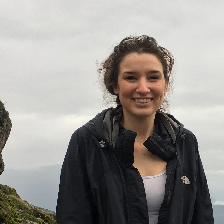

In [5]:
im2

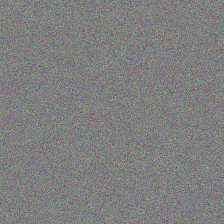

In [6]:
wn = np.clip((np.random.randn(224,224,3)*np.sqrt(255.0))+255.0/2,0,255)
Image.fromarray(np.uint8(wn.reshape(224,224,3)))

# PreProcess Images

In [7]:
def pre_process(x):
    x=x[:,:,::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x
def post_process(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x=x[:,:,::-1]
    return x

In [8]:
style = pre_process(style)
wn = pre_process(wn)
content= pre_process(content)

style=np.expand_dims(style,axis=0)
wn=np.expand_dims(wn,axis=0)
content=np.expand_dims(content,axis=0)

In [9]:
g = tf.Graph()
with g.as_default():
    style_img = tf.constant(style,dtype=tf.float32)
    content_img = tf.constant(content,dtype=tf.float32)
    alter_img = tf.Variable(initial_value=wn,dtype=tf.float32)
    

# Build VGG19

## Extract weights

In [10]:
f = h5py.File("vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [11]:
for l in f.keys():
    print l

block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
input_2


In [12]:
def parse_layer_conv(x):
    if 'conv' in x:
        c = x.split('conv')[-1]
        b = x.split('block')[1].split('_')[0]
        return (c,b)
    else:
        return None

In [13]:
# for l in f.keys():
#     print parse_layer_conv(l)

In [14]:
# x = '1_1'
def getName(x):
    b,c = x.split('_')
    return 'block'+b+'_conv'+c

In [15]:
getName('1_1')

'block1_conv1'

In [16]:
def getW(f,l):
    return f[l].values()[0].value
def getb(f,l):
    return f[l].values()[1].value

In [17]:
c1 = f['block1_conv1'].values()
w1=c1[0].value
b1=c1[1].value

In [18]:
print w1.shape,b1.shape

(3, 3, 3, 64) (64,)


## Add Graph

In [19]:

with g.as_default():
    def vgg19(img):
        # Set up weights as constants
        #Block 1
        w1_1 = tf.constant(getW(f,getName('1_1')))
        b1_1 = tf.constant(getb(f,getName('1_1')))
        w1_2 = tf.constant(getW(f,getName('1_2')))
        b1_2 = tf.constant(getb(f,getName('1_2')))

        #Block 2
        w2_1 = tf.constant(getW(f,getName('2_1')))
        b2_1 = tf.constant(getb(f,getName('2_1')))
        w2_2 = tf.constant(getW(f,getName('2_2')))
        b2_2 = tf.constant(getb(f,getName('2_2')))
        
        #Block 3
        w3_1 = tf.constant(getW(f,getName('3_1')))
        b3_1 = tf.constant(getb(f,getName('3_1')))
        w3_2 = tf.constant(getW(f,getName('3_2')))
        b3_2 = tf.constant(getb(f,getName('3_2')))
        w3_3 = tf.constant(getW(f,getName('3_3')))
        b3_3 = tf.constant(getb(f,getName('3_3')))
        
        #Block 4
        w4_1 = tf.constant(getW(f,getName('4_1')))
        b4_1 = tf.constant(getb(f,getName('4_1')))
        w4_2 = tf.constant(getW(f,getName('4_2')))
        b4_2 = tf.constant(getb(f,getName('4_2')))
        w4_3 = tf.constant(getW(f,getName('4_3')))
        b4_3 = tf.constant(getb(f,getName('4_3')))
        
        #Block 4
        w5_1 = tf.constant(getW(f,getName('5_1')))
        b5_1 = tf.constant(getb(f,getName('5_1')))
        w5_2 = tf.constant(getW(f,getName('5_2')))
        b5_2 = tf.constant(getb(f,getName('5_2')))
        w5_3 = tf.constant(getW(f,getName('5_3')))
        b5_3 = tf.constant(getb(f,getName('5_3')))

        #Add convolution operations
        #Block 1
        conv1_1 = tf.nn.relu(tf.nn.conv2d(img,w1_1,[1,1,1,1],padding='SAME')+b1_1)
        conv1_2 = tf.nn.relu(tf.nn.conv2d(conv1_1,w1_2,[1,1,1,1],padding='SAME')+b1_2)
        pool1 = tf.nn.avg_pool(conv1_2,[1,3,3,1],[1,1,1,1],padding='SAME')

        #Block 2 = 
        conv2_1 = tf.nn.relu(tf.nn.conv2d(pool1,w2_1,[1,1,1,1],padding='SAME')+b2_1)
        conv2_2 = tf.nn.relu(tf.nn.conv2d(conv2_1,w2_2,[1,1,1,1],padding='SAME')+b2_2)
        pool2 = tf.nn.avg_pool(conv2_2,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 3
        conv3_1 = tf.nn.relu(tf.nn.conv2d(pool2,w3_1,[1,1,1,1],padding='SAME')+b3_1)
        conv3_2 = tf.nn.relu(tf.nn.conv2d(conv3_1,w3_2,[1,1,1,1],padding='SAME')+b3_2)
        conv3_3 = tf.nn.relu(tf.nn.conv2d(conv3_2,w3_3,[1,1,1,1],padding='SAME')+b3_3)
        pool3 = tf.nn.avg_pool(conv3_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 4
        conv4_1 = tf.nn.relu(tf.nn.conv2d(pool3,w4_1,[1,1,1,1],padding='SAME')+b4_1)
        conv4_2 = tf.nn.relu(tf.nn.conv2d(conv4_1,w4_2,[1,1,1,1],padding='SAME')+b4_2)
        conv4_3 = tf.nn.relu(tf.nn.conv2d(conv4_2,w4_3,[1,1,1,1],padding='SAME')+b4_3)
        pool4 = tf.nn.avg_pool(conv4_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        #Block 4
        conv5_1 = tf.nn.relu(tf.nn.conv2d(pool4,w5_1,[1,1,1,1],padding='SAME')+b5_1)
        conv5_2 = tf.nn.relu(tf.nn.conv2d(conv5_1,w5_2,[1,1,1,1],padding='SAME')+b5_2)
        conv5_3 = tf.nn.relu(tf.nn.conv2d(conv5_2,w5_3,[1,1,1,1],padding='SAME')+b5_3)
        pool5 = tf.nn.avg_pool(conv5_3,[1,3,3,1],[1,1,1,1],padding='SAME')
        
        return [conv1_1,conv2_1,conv3_1,conv4_1,conv5_1,conv4_2]

# Gram Matrix

# ReWrite with TensorFlow

In [20]:
from keras import backend as K
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    gram = K.dot(features, K.transpose(features))
    return gram

Using TensorFlow backend.


# Train

Compute layers, set up losses, and backprop

In [21]:
alpha = 1.0
beta = 5.0

In [22]:
with g.as_default():
    l_target,l_alter,l_content = vgg19(style_img),vgg19(alter_img),vgg19(content_img)
    
    #Style
    l_target1,l_alter1 = l_target[0],l_alter[0]
    l_target2,l_alter2 = l_target[1],l_alter[1]
    l_target3,l_alter3 = l_target[2],l_alter[2]
    l_target4,l_alter4 = l_target[3],l_alter[3]
    l_target5,l_alter5 = l_target[4],l_alter[4]
    
    g_target1,g_alter1 = gram_matrix(l_target1[0]),gram_matrix(l_alter1[0]) 
    g_target2,g_alter2 = gram_matrix(l_target2[0]),gram_matrix(l_alter2[0])
    g_target3,g_alter3 = gram_matrix(l_target3[0]),gram_matrix(l_alter3[0])
    g_target4,g_alter4 = gram_matrix(l_target4[0]),gram_matrix(l_alter4[0])
    g_target5,g_alter5 = gram_matrix(l_target5[0]),gram_matrix(l_alter5[0])
    
    loss1 = tf.reduce_mean(tf.square(g_alter1 - g_target1))
    loss2 = tf.reduce_mean(tf.square(g_alter2 - g_target2))
    loss3 = tf.reduce_mean(tf.square(g_alter3 - g_target3))
    loss4 = tf.reduce_mean(tf.square(g_alter4 - g_target4))
    loss5 = tf.reduce_mean(tf.square(g_alter5 - g_target5))
    
#     loss = loss1
#     loss = (1.0/2.0)*(loss1+loss2)
#     loss = (1.0/3.0)*(loss1+loss2+loss3)
#     loss = (1.0/4.0)*(loss1+loss2+loss3+loss4)
    loss_style = (1.0/5.0)*(loss1+loss2+loss3+loss4+loss5)
    
    #Content
    l_content1,l_alter1 = l_target[0],l_alter[0]
    l_content2,l_alter2 = l_target[1],l_alter[1]
    l_content3,l_alter3 = l_target[2],l_alter[2]
    l_content4,l_alter4 = l_target[3],l_alter[3]
    l_content5,l_alter5 = l_target[4],l_alter[4]
    
    loss_content = 0.5*tf.reduce_sum(tf.square(l_content[5] - l_alter[5]))
    
    loss = loss_content
    #loss = alpha*loss_style+beta*loss_content
    
    opt = tf.train.AdamOptimizer(learning_rate=1e1,beta1=.9,beta2=.999,epsilon=1e-08).minimize(loss)
#     opt = tf.train.GradientDescentOptimizer(1e-10).minimize(loss)
    
    init = tf.global_variables_initializer()

In [23]:
sess = tf.Session(graph=g)
sess.run(init)
losses=[]

In [24]:
num_steps = 50*200
for i in tqdm(range(num_steps)):
    l,_=sess.run([loss,opt])
    losses.append(l)
    if i %10 == 0:
        after = sess.run(alter_img)
        after = post_process(after[0])
        Image.fromarray(np.uint8(np.clip(after,0,255))).save('Style1/img'+str(i/10)+'.png')

100%|██████████| 10000/10000 [4:20:02<00:00,  1.56s/it]


# Postprocess image

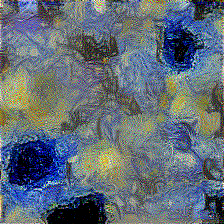

In [25]:
#after = post_process(after[0])
Image.fromarray(np.uint8(np.clip(after,0,255)))

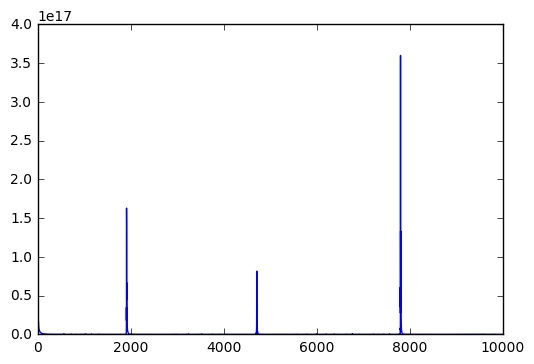

In [27]:
plt.plot(losses)